# Noise sources from experimental measurement

(c) 2018 Manuel Razo. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT). 

---

In [1]:
import os
import cloudpickle
import glob

# Our numerical workhorses
import math
import numpy as np
import pandas as pd
import scipy as sp

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

# Seaborn, useful for graphics
import seaborn as sns

# Import the utils for this project
import chann_cap_utils as chann_cap

# Set PBoC plotting style
chann_cap.set_plotting_style()

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

tmpdir = '../../tmp/'
figdir = '../../fig/experimental_noise_sources/'
datadir = '../../data/csv_maxEnt_dist/'

# $\LaTeX$ macros

$\newcommand{kpon}{k^p_{\text{on}}}$
$\newcommand{kpoff}{k^p_{\text{off}}}$
$\newcommand{kron}{k^r_{\text{on}}}$
$\newcommand{kroff}{k^r_{\text{off}}}$
$\newcommand{rm}{r _m}$
$\newcommand{rp}{r _p}$
$\newcommand{gm}{\gamma _m}$
$\newcommand{gp}{\gamma _p}$
$\newcommand{mm}{\left\langle m \right\rangle}$
$\newcommand{foldchange}{\text{fold-change}}$
$\newcommand{ee}[1]{\left\langle #1 \right\rangle}$
$\newcommand{bb}[1]{\mathbf{#1}}$
$\newcommand{fano}{\text{fano-factor}}$

## Added noise from experimental measurements.

When we experimentally "measure" the protein expression level distribution of our reporter what we actually measure is a noisy representation of this distribution via our measurement instrument. This constraints the information we can infer from our indirect measurement with respect to the real distribution. In particular in information theory the **data processing inequality** tells us that given a Markov chain of the form
$$
X \rightarrow Y \rightarrow Z,
$$
where $X, Y$ and $Z$ are random variables, the mutual information between variables should satisfy
$$
I(X; Z) \leq I(X; Y).
\label{eq:dpi}
$$
In other words, the information cannot be created. If we measure an indirect representation $Z$ of our quantity of interest $Y$, at best we can obtain the exact amount of information about $X$ if there is a deterministic mapping between $Y$ and $Z$. 

What this means is that if we define the chain to be
$$
[\text{inducer}] \rightarrow \text{protein} \rightarrow \text{fluorescence},
$$
our experimental signal can only have at best the same information about the inducer input as the protein itself has. For Eq \ref{eq:dpi} to become an equality we would need a deterministic relationship between protein copy number $p$ and fluorescence intensity $F$. For example linear relationship of the form
$$
F(p) = \alpha p,
$$
where $\alpha$ is the conversion factor between arbitrary units (a.u.) of fluroescence and absolute protein count.

In reality this relationship must be probabilistic, i.e.
$$
P(F \mid p) \sim f(p, \alpha).
$$

The sources of added noise could be
- Emission of photons per fluorescent molecule.
- Quantum efficiency of camera detector.
- Variability in laser light intensity.

As a first approximation let's ignore all the instrument related sources of noise and let's focus on the random emission of photons $\nu$ by a single fluorescent molecule. This quantity depends on the nature of the fluorophore, the light source and the exposure time.

## Poission Emission of Photons

A simple model to account for this added noise is to assume that every time that a fluorophore is excited it emits a photon count $\nu$ such that $\nu \sim \text{Poiss}(\lambda)$, i.e.
$$
P(\nu) = {\lambda^\nu e^{-\lambda} \over \nu!},
$$
where $\lambda = \ee{\nu}$ is the mean number of photons that the protein produces when excited.

If a measured cell has $p$ proteins that emit photons independently of each other, then the total photon count of a cell $N$ is given by
$$
N(p) = \sum_{i=0}^p \nu_i \sim \text{Poiss}(p\lambda).
$$
What this says is that the sum of $p$ iid Poisson random variables with mean $\lambda$ have a Poission distribution with mean $p \lambda$. This statement can be easily proved using MGFs.

This implies that the distribution of fluorescent values per cell we observe $P(N \mid c)$, where $c$ is the inducer concentration are of the form
$$
P(N \mid c) = \sum_{p=0}^\infty P(N \mid p, c) P(p \mid c).
\label{eq:photon_dist}
$$

Since $N$ does not depend directly on $c$ but through the dependence of $p$ on $c$ we have that the first term on the right hand side is our Poisson
$$
P(N \mid p, c) = P(N \mid p) =
{(p \lambda)^N e^{-p\lambda} \over N!}.
$$

## Distribution moments

When we add this Poissonian noise into the distribution we can compute the moments of the photon count distribtution.

### First moment.

For example, our data consists of *iid* samples $\{ N_i \} \sim P(N \mid p, c)$ and we would like to estimate a value for $\lambda$. If we assume that our prediction for $\ee{p}$ is correct then from the experimental dadta we can estimate $\lambda$. First we would compute for the unregulated strain (no $c$ dependence) $\ee{N}_{\text{exp}}$, i.e. the average experimental photon count per cell. Theoretically this would be given by
$$
\ee{N} = \sum_{N=0}^\infty \sum_{p=0}^\infty N P(N \mid p) P(p).
$$
We can rearrange the sums to compute
$$
\ee{N} = \sum_{p=0}^\infty P(p) \left[\sum_{N=0}^\infty N P(N \mid p)\right].
$$

The term indisde the square brackets is just the mean of the Poisson distribution for a given $p$, i.e. $p \lambda$. Therefore we have
$$
\ee{N} = \sum_{p=0}^\infty P(p) p \lambda = \lambda \ee{p}.
$$

#### Estimating $\lambda$ from experimental data.

In order to have an idea of what would we expect $\lambda$, the mean photon count per protein let's first read all microscopy data.

In [74]:
# Define directory where data is stored
expdir = '../../data/microscopy/'

# Define directory where the bootstrap data was stored
bootsdir = '../channcap_exp/'

# List files of data taken exclusively for this experiment
bootsfiles = [x for x in os.listdir(bootsdir) 
              if ('channel_capacity_experiment' in x) &
              ('ipynb' not in x)]

# Extract dates for these experiments
project_dates = [x.split('_')[0] for x in bootsfiles]


# List files with the bootstrap sampling of the
files = glob.glob(expdir + '*csv')

files = glob.glob('../../data/csv_microscopy/*csv')# + mwc_files

# Extract dates from these files
file_dates = [file.split('/')[-1] for file in files]
file_dates = [file.split('_')[0] for file in file_dates]

# Filter for files taken exclusively for this experiment.
files = [file for i, file in enumerate(files) if file_dates[i] in project_dates]

df_micro = pd.concat(pd.read_csv(f, comment='#') for f in files)

df_micro[['date', 'operator', 'rbs', 'mean_intensity', 'area']].tail()

,date,operator,rbs,mean_intensity,area
6294,20180327,O3,RBS1L,1470.462192,3.7120
6295,20180327,O3,RBS1L,2976.900676,3.9168
6296,20180327,O3,RBS1L,3018.368572,4.9408
6297,20180327,O3,RBS1L,2249.099376,5.8368
6298,20180327,O3,RBS1L,1816.220523,3.1488


Now let's take the $\Delta$*lacI* data and compute the mean photon count per cell.

In [77]:
# Define interpixel distance
IPDIST = 0.160  # in units of µm per pixel

# Extract ∆lacI strain data
df_delta = df_micro[(df_micro['rbs'] == 'delta') |
                    (df_micro['rbs'] == 'auto')]

# Extract dates
df_group = df_delta.groupby(['date', 'IPTG_uM'])

# Initialize dataframe to save experimental fano-factor of 
# the unregulated promoter
names = ['date', 'operator', 'IPTG_uM', 'mean_fluor']
df_mean_delta = pd.DataFrame(columns=names)

# Loop through dates computing the mean at each group correcting by the
# autolfuorecence value
for group, data in df_group:
    # Compute mean autofluorescence
    mean_auto = (data[data['rbs'] == 'auto'].mean_intensity *
                 data[data['rbs'] == 'auto'].area / IPDIST**2).mean()
    
    # Correct all of the ∆lacI measurements extracting the mean autofluorescence
    delta_fluor = (data[data['rbs'] == 'delta'].mean_intensity *
                   data[data['rbs'] == 'delta'].area / IPDIST**2) - mean_auto
   
    # Compute and save the fano-factor
    mean_data = pd.Series([group[0], data['operator'].unique()[0], group[1],
                           delta_fluor.mean()], index=names)
    
    df_mean_delta = df_mean_delta.append(mean_data, ignore_index=True)
    
df_mean_delta.tail()

,date,operator,IPTG_uM,mean_fluor
22,20180417,O1,5000.0,376043.833032
23,20180418,O3,0.0,388530.694634
24,20180418,O3,5000.0,480614.669786
25,20180419,O3,0.0,330798.306059
26,20180419,O3,5000.0,564345.547659


Let's look at the distribution of these values per operator.

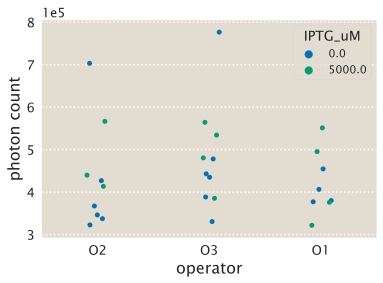

In [78]:
ax = sns.stripplot(x='operator', y='mean_fluor', data=df_mean_delta,
                   hue='IPTG_uM', jitter=True, dodge=False)
ax.set_ylabel('photon count')
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

So the value is something between $3\times 10^5$ and $8\times 10^5$.

Now we need to compute what the mean protein copy number for the unregulated promoter is given our parameters. Let's define the parameters and load the functions to compute the moments.

In [79]:
# List the parameters fit for the lacUV5 promoter
par_UV5 = dict(kp_on=5.5, kp_off=28.9, rm=87.6, gm=1)

# define protein degradation rate in units of mRNA degradation rate
gp = 0.000277 / 0.00284 
par_UV5['gp'] = gp

# define rp based on the mean protein copy number per mRNA
par_UV5['rp'] = 1000 * par_UV5['gp']

# Load moment functions for the two-state unregulated case
with open('./two_state_moments_lambdify.dill', 'rb') as file:
    mom_unreg_dict = cloudpickle.load(file)

Having defined the parameters let's compute the mean number of protein.

In [80]:
# Extract parameters in the correct order
param = ['kp_on', 'kp_off', 'rm', 'gm', 'rp', 'gp']
par = [par_UV5.get(x) for x in param]

# Compute mean protein copy number
mean_p = float(mom_unreg_dict[(0, 1)](*par))

print('<p> = {0:.1f}'.format(mean_p))

<p> = 14005.8


Now that we have this estimate of the mean protein copy number $\ee{p}$ for the unregualted promoter and the mean fluorescence per cell $\ee{N}$ we can estimate $\lambda$ by using the relationship
$$
\ee{N} = \ee{p} \lambda.
$$

In [67]:
# Estimate lambda
lam_exp = df_mean_delta.mean_fluor.mean() / mean_p
print('mean photon count per protein = {:.0f}'.format(lam_exp))

mean photon count per protein = 32


### Second moment.

The second moment of the cell photon count is given by
$$
\ee{N^2} = \sum_{N=0}^\infty \sum_{p=0}^\infty N^2 P(N \mid p) P(p).
$$
We again rewrite this as
$$
\ee{N^2} = \sum_{p=0}^\infty P(p) \left[\sum_{N=0}^\infty N^2 P(N \mid p)\right].
$$
We see again the same pattern where the term in brackets is the second moment of the Poisson distribution. This gives
$$
\ee{N^2} = \sum_{p=0}^\infty P(p) \left[ (p \lambda)^2 + (p \lambda) \right] =
\lambda^2 \ee{p^2} + \lambda \ee{p}.
$$

### Variance and fano-factor.

Given that we have the first and second moment of the intensity distribution as a function of the mean photon count per protein $\lambda$ and the moments of the protein distribution we can compute the Variance
$$
\sigma_N^2 \equiv \ee{N^2} - \ee{N}^2 = 
\lambda^2 \ee{p^2} + \lambda \ee{p} - \lambda^2 \ee{p}^2.
$$
This can be rewritten as
$$
\sigma_N^2 = \lambda^2 \left[ \ee{p^2} - \ee{p}^2 \right] + \lambda \ee{p}.
$$
In this form we see that the term in square brackets is the variance in the protein copy number $\sigma_p^2$. Since the extra term $\lambda \ee{p}$ remains there we see that the variance increases linearly with the number of proteins and the mean photon count per protein.

The fano-factor, defined as Variance / mean for this case is given by
$$
\fano_N = {\lambda^2 \left[ \ee{p^2} - \ee{p}^2 \right] + \lambda \ee{p}
\over \lambda \ee{p}} =
\lambda \left[ {\ee{p^2} - \ee{p}^2 \over \ee{p}}  \right] + 1.
\label{eq:fano_photons}
$$

#### Exploring the fano-factor.

Let's explore the consequences of Eq. \ref{eq:fano_photons}. We will define a function to compute the fano factor as a function of the mean photon count per protein $\lambda$ and the master equation parameters.

First let's import the function for the master equation moments.

In [81]:
# Unregulated two-state promoter
# Parameters are feed in the following order:
# (kp_on, kp_off, rm, gm, rp, gp)
with open('./two_state_moments_lambdify.dill', 'rb') as file:
    mom_unreg_dict = cloudpickle.load(file)
    
# Regulated three-state promoter
# Parameters are feed in the following order:
# (kr_on, kr_off, kp_on, kp_off, rm, gm, rp, gp)
with open('./three_state_moments_lambdify.dill', 'rb') as file:
    mom_reg_dict = cloudpickle.load(file)

Now let's define a function to compute the fano factor for an unregulated two-state promoter.

In [82]:
def fano_unreg(lam, kp_on, kp_off, rm, gm, rp, gp):
    '''
    Computes the fano-factor (variance / mean) for a two-state unregulated 
    promoter at the protein level assuming a Poission emission of photons per
    fluorophore.
    Parameters
    ----------
    lam : float.
        Mean photon count per protein
    kp_on : float.
        RNAP on rate. [time**-1]
    kp_off : float.
        RNAP off rate. [time**-1]
    rm : float.
        transcription initiation rate. [time**-1]
    gm : float.
        mRNA degradation rate. [time**-1]
    mRNA : bool. Default = True
        Boolean indicating if it should be computed for the mRNA level.
        If false it is computed for the protein level
    Returns
    -------
    fano-factor for an unregulated promoter at the photon count level.
    '''
    par = [kp_on, kp_off, rm, gm, rp, gp]
    
    first_mom = mom_unreg_dict[(0, 1)](*par)
    second_mom = mom_unreg_dict[(0, 2)](*par)
                  
    return lam * (second_mom - first_mom**2) / first_mom + 1

Let's define the parameters for the unregulated promoter.

In [83]:
# List the parameters fit for the lacUV5 promoter
par_UV5 = dict(kp_on=5.5, kp_off=28.9, rm=87.6, gm=1)

# define protein degradation rate in units of mRNA degradation rate
gp = 0.000277 / 0.00284 
par_UV5['gp'] = gp

# define rp based on the mean protein copy number per mRNA
par_UV5['rp'] = 1000 * par_UV5['gp']

The fano-factor using the $\lambda$ inferred from the first moment gives

In [84]:
print('fano-factor unreg promoter: {:.1f}'.format(fano_unreg(32, **par_UV5)))

fano-factor unreg promoter: 8960.1


#### Computing the experimental fano-factor.

Let's compute the fano-factor for each date.

In [85]:
# Define interpixel distance
IPDIST = 0.160  # in units of µm per pixel

# Extract dates
df_group = df_delta.groupby(['date', 'IPTG_uM'])

# Initialize dataframe to save experimental fano-factor of 
# the unregulated promoter
names = ['date', 'operator', 'IPTG_uM', 'mean_fluor', 'var_fluor', 'fano_factor']
df_fano_unreg = pd.DataFrame(columns=names)

# Loop through dates computing the fano-factor at each point
for group, data in df_group:
    # Compute mean autofluorescence
    mean_auto = (data[data['rbs'] == 'auto'].mean_intensity *
                 data[data['rbs'] == 'auto'].area / IPDIST**2).mean()
    
    # Correct all of the ∆lacI measurements extracting the mean autofluorescence
    delta_fluor = (data[data['rbs'] == 'delta'].mean_intensity *
                   data[data['rbs'] == 'delta'].area / IPDIST**2) - mean_auto
   
    # Compute and save the fano-factor
    fano_data = pd.Series([group[0], data['operator'].unique()[0], group[1],
                           delta_fluor.mean(), delta_fluor.var(),
                           delta_fluor.var() / delta_fluor.mean()],
                          index=names)
    
    df_fano_unreg = df_fano_unreg.append(fano_data, ignore_index=True)
    
df_fano_unreg.tail()

,date,operator,IPTG_uM,mean_fluor,var_fluor,fano_factor
22,20180417,O1,5000.0,376043.833032,1.919344e+10,51040.437299
23,20180418,O3,0.0,388530.694634,2.840604e+10,73111.443906
24,20180418,O3,5000.0,480614.669786,3.138083e+10,65293.113904
25,20180419,O3,0.0,330798.306059,4.520123e+10,136642.863945
26,20180419,O3,5000.0,564345.547659,3.914984e+10,69372.102221


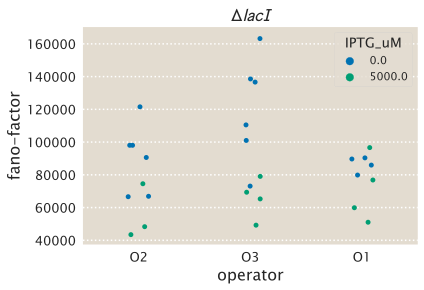

In [87]:
ax = sns.stripplot(x='operator', y='fano_factor', data=df_fano_unreg,
                   hue='IPTG_uM', jitter=True, dodge=False)
ax.set_ylabel('fano-factor')
ax.set_title('$\Delta lacI$')
# ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

In [88]:
print('fano-factor experimental: ', int(df_fano_unreg.fano_factor.mean()))

fano-factor experimental:  86084


In [89]:
print('fano-factor unreg promoter: {:.1f}'.format(fano_unreg(32, **par_UV5)))

fano-factor unreg promoter: 8960.1


#### Coding Poission noise. 

Let's now define a function such that given a value for $\lambda$ it takes our MaxEnt protein distribution and maps it into Eq. \ref{eq:photon_dist}.

#### `numba.jit` the Poisson distribution

Given that computing the Poission distribution over and over again is a computationally demanding process we will code a `just in time compilation` function with numba that should be faster than the non-compiled `scipy` equivalent function. For this we will use the package `math` to perform the numerical computations.

Let's code both a `numba` and a `scipy` version of what we are trying to compute.

In [75]:
@numba.jit(nopython=True)
def poiss_numba(lam, protein, photons):
    # Initialize matrix to save distribution
    PNp = np.empty((len(protein), len(photons)))
    
    # Loop through each value of the protein and the photons
    for i, p in enumerate(protein):
        for j, photon in enumerate(photons):
            PNp[i, j] = math.exp((-p * lam) + photon * math.log(p * lam)
                                 - math.lgamma(photon + 1))
        
    return PNp


def poiss_scipy(lam, protein, photons):
    # Initialize matrix to save distribution
    PNp = np.empty((len(protein), len(photons)))
    
    # Loop through each value of the protein and the photons
    for i, p in enumerate(protein):
        PNp[i, :] = sp.stats.poisson.pmf(photons, p * lam)
    return PNp

Now let's define some example parameters to input into this function.

In [76]:
# Define the mean number of photons per protein
lam = 32

# Define a set of mean proteins
protein = [10, 100, 1000]

# Define the number of photons based on these numbers
photons = np.arange(0, lam * max(protein) * 1.5)

Let's compare the timing of both functions

In [78]:
%%timeit
poiss_numba(lam, protein, photons)

6.26 ms ± 13.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [79]:
%%timeit
poiss_scipy(lam, protein, photons)

25 ms ± 111 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


We are getting almost a factor of 5 in speed boost!

Let's just make sure that the values that we are obtaining with the `numba` function are actually the same as the ones `scipy` gives.

In [80]:
dist_numba = poiss_numba(lam, protein, photons)
dist_scipy = poiss_scipy(lam, protein, photons) 
np.allclose(dist_numba, dist_scipy)

True

Now let's define the function to compute the distribution.

In [91]:
def photons_poisson(lam, mRNA, protein, lagrange,
                     exponents=[(1, 0), (2, 0), (3, 0),
                                (0, 1), (0, 2), (1, 1)]):
    '''
    Computes the photon count distribution P(N) given a poission emission of
    photons per fluorophore with mean photon count per protein performing a
    convolution between the Poisson emission of photons with the MaxEnt protein
    distribution.
    
    Parameters
    ----------
    lam : float.
        Mean number of photon counts per protein.
    mRNA, protein : array-like.
        Sample space for both the mRNA and the protein.
    lagrange : array-like.
        Array containing the value of the Lagrange multipliers associated
        with each of the constraints.
    exponents : list. leng(exponents) == len(lagrange)
        List containing the exponents associated with each constraint.
        For example a constraint of the form <m**3> has an entry (3, 0)
        while a constraint of the form <m * p> has an entry (1, 1).
        
    Returns
    -------
    Pmp : array-like.
        Photon count per cell distribution.
    '''
    # Compute the MaxEnt mRNA-protein joint distribution
    Pmp = chann_cap.maxEnt_from_lagrange(mRNA, protein, lagrange, exponents)
    
    # Marginalize out the mRNA to obtain the protein distribution
    Pp = np.sum(Pmp, axis=1)
    
    # Generate array of photon counts
    photons = np.arange(0, lam * max(protein) * 1.5)
    
    PNp = poiss_numba(lam, protein, photons) * Pp
    
    # Marginalize out the protein counts and return photon distribution
    return photons, PNp

Now that we coded up this distribution let's look at the distribution using the MaxEnt inferences made for the experimentally available strains.

In [88]:
# Read MaxEnt infered Lagrange multipliers
df_maxEnt = pd.read_csv(datadir + 'MaxEnt_ss_Lagrange_multipliers_HGRP_2011.csv',
                        index_col=0)

df_maxEnt.head()

,operator,binding_energy,repressor,inducer_uM,lambda_m1p0,lambda_m2p0,lambda_m3p0,lambda_m0p1,lambda_m0p2,lambda_m0p3,lambda_m1p1,lambda_m2p1,lambda_m1p2
0,O1,-15.3,0.0,0.0,-0.033557,-0.024963,0.000406,0.006585,-3.672393e-07,5.400445e-12,0.000049,-4.798241e-07,-2.835945e-10
1,O1,-15.3,0.0,0.1,-0.033557,-0.024963,0.000406,0.006585,-3.672393e-07,5.400445e-12,0.000049,-4.798241e-07,-2.835945e-10
2,O1,-15.3,0.0,1.0,-0.033557,-0.024963,0.000406,0.006585,-3.672393e-07,5.400445e-12,0.000049,-4.798241e-07,-2.835945e-10
3,O1,-15.3,0.0,5.0,-0.033557,-0.024963,0.000406,0.006585,-3.672393e-07,5.400445e-12,0.000049,-4.798241e-07,-2.835945e-10
4,O1,-15.3,0.0,7.5,-0.033557,-0.024963,0.000406,0.006585,-3.672393e-07,5.400445e-12,0.000049,-4.798241e-07,-2.835945e-10


Let's extract the Lagrange multipliers for a specific strain.

In [92]:
# Define sample space
mRNA_space = np.arange(0, 40)
protein_space = np.arange(0, 2.3E4)

# Extract inference from data frame
df_sample = df_maxEnt[(df_maxEnt.operator == 'O2') &
                      (df_maxEnt.repressor == 260) &
                      (df_maxEnt.inducer_uM == 75)]

# Select the Lagrange multipliers
lagrange_sample =  df_sample.loc[:, [col for col in df_sample.columns 
                                     if 'lambda' in col]].values[0]

And now let's compute the distribution with the Poission noise

In [ ]:
# Compute distribution from Lagrange multipliers values
photons, PNp = photons_poisson(int(lam_exp), mRNA_space, protein_space, 
                               lagrange_sample,
                               exponents=[(1, 0), (2, 0), (3, 0), 
                                          (0, 1), (0, 2), (0, 3),
                                          (1, 1), (2, 1), (1, 2)])

In [ ]:
chann_cap.joint_marginal_plot(photons, protein_space, PNp.T,
                              xlabel='protein / cell', ylabel='photon count')

In [ ]:
plt.plot(photons, PN)
plt.xlabel(r'photon count $\nu$')
plt.ylabel('probability')